In [27]:
import pandas as pd, numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas
import matplotlib as plot

In [49]:
geo_path = 'GIS/Tracts/cb_2017_06_tract_500k/' # select folder with data in it
ca_tracts = geopandas.read_file(geo_path + 'cb_2017_06_tract_500k.shp')

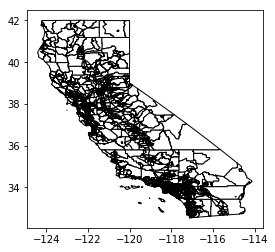

In [44]:
ca_tracts.plot(color='white', edgecolor='black')

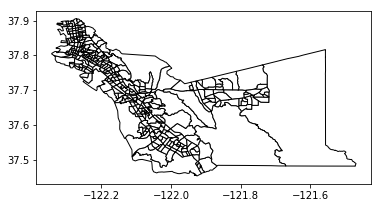

In [43]:
#let's check Alameda County

ca_tracts[ca_tracts.COUNTYFP=='001'].plot(color='white', edgecolor='black')

I think we need to change the Coordinate Reference System to be able to measure the buffers around the stations. I think the default uses the euclidean distance and measures in degrees or something and I don't know how to interpret that.

We'll use the MTC standardized CRS for now and the unit of meters. We may want to switch to a better state-wide representation or do different parts of the state separately if we want to get more exact. MTC has standardized on Universal Transverse Mercator (UTM), Zone 10N, NAD83 for all analysis based projects.

In [50]:
print(ca_tracts.crs)

mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
ca_tracts = ca_tracts.to_crs(mtc_crs)

print(ca_tracts.crs)

{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


In [102]:
ca_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400600,1400000US06001400600,06001400600,4006,CT,297856,0,"POLYGON ((564397.7068758229 4188774.178144514,..."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((562861.1478494926 4188278.724707939,..."
2,06,001,401400,1400000US06001401400,06001401400,4014,CT,758204,0,"POLYGON ((563485.050109303 4186852.16606663, 5..."
3,06,001,403000,1400000US06001403000,06001403000,4030,CT,352394,0,"POLYGON ((563848.3701941479 4183743.177766136,..."
4,06,001,405902,1400000US06001405902,06001405902,4059.02,CT,487280,0,"POLYGON ((566284.6164856911 4182772.696033466,..."


In [92]:
stop_path = 'station_id/'
dtypes = {'Stop ID': 'str', 'Name': 'str', 'Agency': 'str', 'OB Routes': 'str', 'IB Routes': 'str'}
stops = pd.read_csv(stop_path + 'AllBus.csv', delimiter=',', dtype=dtypes)
print(len(stops))
stops.head()

98913


,Unnamed: 0,Stop ID,Name,Agency,X,Y,OB Routes,OB AM Peak,OB PM Peak,OB Weekday,OB Saturday,OB Sunday,IB Routes,IB AM Peak,IB PM Peak,IB Weekday,IB Saturday,IB Sunday
0,0,777402,San Jose Caltrain Station,Caltrain,-121.901985,37.330196,TaSJ-Shuttle,NaN,NaN,NaN,93.33,93.33,TaSJ-Shuttle,NaN,NaN,NaN,70.00,70.00
1,1,777403,Tamien Caltrain Station,Caltrain,-121.883403,37.311638,TaSJ-Shuttle,NaN,NaN,NaN,93.33,93.33,TaSJ-Shuttle,NaN,NaN,NaN,70.00,70.00
2,0,2452018,San Rafael Transit Center,Marin Transit,-122.523102,37.971081,"125, 245, 29, 22, 49, 228, 35, 68, 233, 36, 25...",8.0,7.5,8.5,10.91,10.91,"125, 245, 29, 22, 49, 228, 35, 68, 233, 36, 25...",7.74,8.89,8.97,9.44,9.55
3,1,2452379,Hwy 101 @ Lucky Dr Bus Pad,Marin Transit,-122.517030,37.937937,NaN,NaN,NaN,NaN,NaN,NaN,"36, 17",18.46,17.14,20.43,25.45,25.45
4,2,2452231,Hwy 101 @ Tamalpais Dr Bus Pad,Marin Transit,-122.515205,37.926495,119,NaN,240.0,480.0,NaN,NaN,"36, 17",18.46,17.14,20.43,25.45,25.45


Now we will limit the stops based on the criteria we have defined. In SB 827, this was:

--> 15-minute headways during the AM Peak (6am - 10am) and PM Peak (3pm - 7pm)

--> 20-minute headways every weekday from 6am - 10am

--> 30-minute headways on Saturday and Sunday from 8am - 10pm

In [93]:
qual_stops = stops[((stops['OB AM Peak']<=15) | (stops['IB AM Peak']<=15)) & 
                   ((stops['OB PM Peak']<=15) | (stops['IB PM Peak']<=15)) & 
                   ((stops['OB Weekday']<=20) | (stops['IB Weekday']<=20)) & 
                   ((stops['OB Saturday']<=30) | (stops['IB Saturday']<=30)) & 
                   ((stops['OB Sunday']<=30) | (stops['IB Sunday']<=30))].reset_index()
print(len(qual_stops))

15635


Next step is to use the longitude and latitude variables (X and Y) to transform this dataframe into a database

In [94]:
qual_stops['Coordinates'] = list(zip(qual_stops.X, qual_stops.Y))
qual_stops['Coordinates'] = qual_stops['Coordinates'].apply(Point)
geo_stops = geopandas.GeoDataFrame(qual_stops, geometry='Coordinates')

In [95]:
geo_stops.crs = {'init': 'epsg:4269'} #setting the coordinate reference system to match the tracts
print(geo_stops.crs)

geo_stops = geo_stops.to_crs(mtc_crs)
print(geo_stops.crs)

{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


Let's plot the two geodataframes to see how it looks

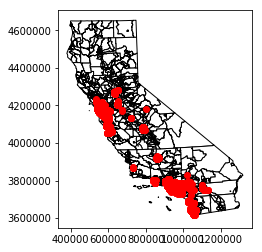

In [96]:
ax = ca_tracts.plot(color='white', edgecolor='black')

# We can now plot our GeoDataFrame.
geo_stops.plot(ax=ax, color='red')

Now we have to try to buffer the 1/4 mile radius around the stations. We'll replace the original point Coordinates with polygons that have the circles since I haven't figured out how to make it work in a separate column.

In [97]:
geo_stops['Coordinates'] = geo_stops['Coordinates'].buffer(402)

geo_stops.head()

,index,Unnamed: 0,Stop ID,Name,Agency,X,Y,OB Routes,OB AM Peak,OB PM Peak,OB Weekday,OB Saturday,OB Sunday,IB Routes,IB AM Peak,IB PM Peak,IB Weekday,IB Saturday,IB Sunday,Coordinates
0,2,0,2452018,San Rafael Transit Center,Marin Transit,-122.523102,37.971081,"125, 245, 29, 22, 49, 228, 35, 68, 233, 36, 25...",8.00,7.50,8.50,10.91,10.91,"125, 245, 29, 22, 49, 228, 35, 68, 233, 36, 25...",7.74,8.89,8.97,9.44,9.55,"POLYGON ((542288.9258724623 4202713.659785125,..."
1,6,4,2452345,Reed Blvd & Redwood Hwy,Marin Transit,-122.514992,37.901085,"17, 22, 115",18.46,18.46,22.33,30.00,30.00,"219, 17, 22",13.33,12.00,14.12,19.09,19.09,"POLYGON ((543041.665031161 4194951.153077608, ..."
2,7,5,2452101,Reed Blvd & Belvedere Dr,Marin Transit,-122.513275,37.898609,"219, 17, 22, 115",12.00,12.00,14.55,18.26,18.26,"219, 17, 22, 115",15.00,12.00,14.55,19.53,19.53,"POLYGON ((543194.0502280053 4194677.2243268, 5..."
3,8,6,2452202,Belvedere Dr & Redwood Hwy Frontage Rd,Marin Transit,-122.514671,37.897598,"219, 17, 22",12.63,11.43,14.33,17.50,17.50,"219, 17, 22, 115",17.14,17.14,20.87,36.52,36.52,"POLYGON ((543071.8991655895 4194564.413179142,..."
4,26,24,2452032,Marin City Hub,Marin Transit,-122.511070,37.871777,"22, 115, 36, 17, 71X, 61",10.43,8.57,11.57,14.24,14.24,"22, 115, 36, 17, 71X, 61",9.23,9.23,11.03,15.27,15.27,"POLYGON ((543403.5120270737 4191701.203396986,..."


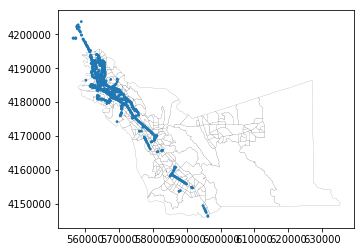

In [98]:
#Let's check for Alameda

base = ca_tracts[ca_tracts.COUNTYFP=='001'].plot(color='white', edgecolor='black', linewidth=.1)
geo_stops[geo_stops.Agency=='AC Transit'].plot(ax=base);

In [99]:
res_union = geopandas.overlay(ca_tracts, geo_stops, how='union')

res_union.head()

,AFFGEOID,ALAND,AWATER,Agency,COUNTYFP,GEOID,IB AM Peak,IB PM Peak,IB Routes,IB Saturday,...,OB Sunday,OB Weekday,STATEFP,Stop ID,TRACTCE,Unnamed: 0,X,Y,index,geometry
0,1400000US06001400600,297856.0,0.0,AC Transit,001,06001400600,10.43,10.0,"6, 800",15.0,...,NaN,NaN,06,1020280,400600,1284.0,-122.262017,37.840356,71203.0,"POLYGON ((564978.9780164432 4188758.12380546, ..."
1,1400000US06001400400,714728.0,0.0,AC Transit,001,06001400400,10.43,10.0,"6, 800",15.0,...,NaN,NaN,06,1020280,400400,1284.0,-122.262017,37.840356,71203.0,"POLYGON ((564950.9881445128 4188518.22503095, ..."
2,1400000US06001400300,1105329.0,0.0,AC Transit,001,06001400300,10.43,10.0,"6, 800",15.0,...,NaN,NaN,06,1020280,400300,1284.0,-122.262017,37.840356,71203.0,"POLYGON ((564744.9932283605 4188317.651189192,..."
3,1400000US06001401100,883273.0,0.0,AC Transit,001,06001401100,10.43,10.0,"6, 800",15.0,...,NaN,NaN,06,1020280,401100,1284.0,-122.262017,37.840356,71203.0,"POLYGON ((564663.8718861116 4188061.494909854,..."
4,1400000US06001400600,297856.0,0.0,AC Transit,001,06001400600,NaN,NaN,NaN,NaN,...,15.27,11.43,06,1020370,400600,1254.0,-122.261572,37.841687,71173.0,"POLYGON ((564738.711670726 4188834.218121335, ..."


In [101]:
res_union.to_csv('tract_stop.csv')